<a href="https://colab.research.google.com/github/hon3538/AI/blob/main/KT_AIVLE/%EC%9C%A0%ED%86%B5_%ED%8C%90%EB%A7%A4%EB%9F%89_%EC%98%88%EC%B8%A1_%EB%B0%8F_%EC%9E%AC%EA%B3%A0_%EC%B5%9C%EC%A0%81%ED%99%94/%EB%AA%A8%EB%8D%B8%EB%A7%81_%EB%B0%8F_%EB%B9%84%EC%A6%88%EB%8B%88%EC%8A%A4_%ED%8F%89%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/미니 프로젝트/시계열/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

In [ ]:
def preproc3d(data, timesteps, y_scale = False) :
    target = 'target'
    x = data.drop(['Date','year','WTI_Price', target], axis = 1)
    y = data.loc[:, target]

    # 가변수화
    x = pd.get_dummies(x, columns = ['weekday','holiday'])
    col_names = list(x)


    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 60, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [ ]:
!pip install workalendar
from workalendar.usa import UnitedStates

cal = UnitedStates()
holiday = pd.DataFrame()
for y in range(2014, 2018) :
    holiday = pd.concat([holiday, pd.DataFrame(cal.holidays(y))], axis = 0)

holiday.columns = ['Date', 'holiday']
holiday['Date'] = pd.to_datetime(holiday['Date'])
holiday['holiday'] = 1 # 휴일은 1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=1dda368b4ef0e9b0d3a736f08e27ccb4bfd8b1f0803f20b7a7cc0bba35c9e2d3
  Stored in directory: /root/.cache/pip/wheels/d6/67/78/aa2e8d108639dd23a5e9e72a4fc88bb44f5541894382712f48
Successfully built pymeeus


In [ ]:
def set_dataframe(Product_ID, Store_ID =44):
  lead_time = products.loc[products['Product_ID'] == Product_ID]['LeadTime'].item()
  sale = sales.loc[(sales['Store_ID'] == Store_ID)&(sales['Product_ID'] == Product_ID)][['Date','Qty']]
  order = orders.loc[(orders['Store_ID'] == Store_ID)][['Date','CustomerCount']]
  sale_order_merge = pd.merge(sale, order, on = 'Date', how = 'left')
  sale_order_merge['target'] = sale_order_merge['Qty'].shift(-lead_time)
  sale_order_merge.dropna(axis = 0, inplace = True)

  #date
  sale_order_merge['year'] = sale_order_merge['Date'].dt.year
  sale_order_merge['day'] = sale_order_merge['Date'].dt.day
  sale_order_merge['weekday'] = sale_order_merge['Date'].dt.weekday
  sale_order_merge['Month'] = sale_order_merge['Date'].dt.month
  #hour은 모두 0시로 통일되어있음

  #same_category 의미가있나.?
  same_cate = products.loc[products['Product_ID']==Product_ID]['Category'].item()
  product_id = products.loc[products['Category']==same_cate]['Product_ID'].tolist()
  same_category = sales.loc[(sales['Store_ID'] == Store_ID)&(sales['Product_ID'].isin(product_id))].groupby('Date',as_index = False)[['Qty']].sum()
  same_category.rename(columns ={"Qty": 'Category_Qty'},inplace = True)
  sale_order_merge = pd.merge(sale_order_merge, same_category, on = 'Date', how = 'left')

  #
  store_type = stores.loc[stores['Store_ID']==Store_ID]['Store_Type'].item()
  city = stores.loc[stores['Store_ID']==Store_ID]['City'].item()
  store_id = stores.loc[(stores['City']==city)&(stores['Store_Type']==store_type)]['Store_ID'].tolist()
  same_type_store = orders.loc[orders['Store_ID'].isin(store_id)].groupby('Date',as_index = False)[['CustomerCount']].sum()
  same_type_store.rename(columns ={"CustomerCount": 'Sametype_CustomerCount'},inplace = True)
  sale_order_merge = pd.merge(sale_order_merge, same_type_store, on = 'Date', how = 'left')

  # 2.4 oil price MA14
  sale_order_merge = pd.merge(sale_order_merge, oil_price, on = 'Date', how = 'left')
  sale_order_merge['WTI_Price'] = sale_order_merge['WTI_Price'].rolling(14, min_periods=1).mean()

  sale_order_merge['Customer_congestion'] = np.where(sale_order_merge['CustomerCount'] <= 3500, 0,
                                 np.where(sale_order_merge['CustomerCount'] <= 4500, 1,
                                         np.where(sale_order_merge['CustomerCount'] <= 6000, 2, 3)))

  #공휴일추가
  sale_order_merge=pd.merge(sale_order_merge,holiday,how='left')
  sale_order_merge = sale_order_merge.fillna({'holiday':0}) # 휴일이 아닌 날은 0
  sale_order_merge['holiday'] = np.where(sale_order_merge['weekday'].isin([5, 6]), 1, 0) # 주말도 휴무일에 넣음


  total_df = sale_order_merge.copy()
  return total_df

In [ ]:
df = set_dataframe(3, 44)

# **2.모델링**

In [ ]:
df.describe()

,Date,Qty,CustomerCount,target,year,day,weekday,Month,Category_Qty,Sametype_CustomerCount,WTI_Price,Customer_congestion,holiday
count,1144,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000
mean,2015-07-30 10:31:53.286713088,8736.909091,4402.983392,8718.649476,2015.097028,15.737762,2.998252,6.284091,9079.046329,21556.840909,61.545266,1.356643,0.285839
min,2014-01-02 00:00:00,2853.000000,2510.000000,0.000000,2014.000000,1.000000,0.000000,1.000000,3028.000000,14407.000000,28.978889,0.000000,0.000000
25%,2014-10-14 18:00:00,6577.250000,3856.500000,6569.500000,2014.000000,8.000000,1.000000,3.000000,6878.500000,18464.000000,45.340000,1.000000,0.000000
50%,2015-07-29 12:00:00,8029.500000,4232.500000,8024.500000,2015.000000,16.000000,3.000000,6.000000,8375.500000,20106.000000,50.422000,1.000000,0.000000
75%,2016-05-14 06:00:00,10295.250000,4864.500000,10320.000000,2016.000000,23.000000,5.000000,9.000000,10667.750000,24772.000000,87.042000,2.000000,1.000000
max,2017-02-26 00:00:00,25413.000000,8359.000000,25413.000000,2017.000000,31.000000,6.000000,12.000000,25413.000000,43111.000000,107.134000,3.000000,1.000000
std,NaN,3610.067205,728.751034,3639.681473,0.906007,8.751919,1.999124,3.521794,3639.643966,4190.623306,23.898058,0.579988,0.452011


* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_test, y_test
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x[i:i+timesteps])
        output_y.append(y[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
# df = joblib.load(path+'data.pkl')

In [ ]:
df.columns

Index(['Date', 'Qty', 'CustomerCount', 'target', 'year', 'day', 'weekday',
       'Month', 'Category_Qty', 'Sametype_CustomerCount', 'WTI_Price',
       'Customer_congestion', 'holiday'],
      dtype='object')

In [ ]:
df

,Date,Qty,CustomerCount,target,year,day,weekday,Month,Category_Qty,Sametype_CustomerCount,WTI_Price,Customer_congestion,holiday
0,2014-01-02,9853.0,4422.0,15153.0,2014,2,3,1,10142.0,23307,95.140000,1,0
1,2014-01-03,8647.0,4167.0,15606.0,2014,3,4,1,8980.0,21287,94.400000,1,0
2,2014-01-04,15153.0,5341.0,7900.0,2014,4,5,1,15684.0,28859,94.400000,2,1
3,2014-01-05,15606.0,5123.0,7188.0,2014,5,6,1,15606.0,28054,94.400000,2,1
4,2014-01-06,7900.0,3917.0,8800.0,2014,6,0,1,8083.0,19589,93.973333,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,7856.0,3834.0,10208.0,2017,22,2,2,8118.0,18528,53.395556,1,0
1140,2017-02-23,8018.0,3955.0,12361.0,2017,23,3,2,8316.0,19011,53.561111,1,0
1141,2017-02-24,10208.0,4549.0,10108.0,2017,24,4,2,10689.0,21501,53.577778,2,0
1142,2017-02-25,12361.0,4619.0,10006.0,2017,25,5,2,13073.0,24771,53.577778,2,1


In [ ]:
# Date 제거
df = df.drop(columns=['Date'])
df.head()

# 가변수화
cat_cols = ['Month', 'weekday']
# cat_cols = ['Month', 'Weekday']  # 내꺼
df = pd.get_dummies(df, columns=cat_cols ,drop_first=True)


In [ ]:
# X, y 분리
target = 'target'
X = df.drop(target, axis=1)
y = df.loc[:, target]

display(X)
# 스케일링
scaler_x = MinMaxScaler()
X = scaler_x.fit_transform(X)

y = y**0.5

X.shape, y.shape

,Qty,CustomerCount,year,day,Category_Qty,Sametype_CustomerCount,WTI_Price,Customer_congestion,holiday,Month_2,...,Month_9,Month_10,Month_11,Month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,9853.0,4422.0,2014,2,10142.0,23307,95.140000,1,0,False,...,False,False,False,False,False,False,True,False,False,False
1,8647.0,4167.0,2014,3,8980.0,21287,94.400000,1,0,False,...,False,False,False,False,False,False,False,True,False,False
2,15153.0,5341.0,2014,4,15684.0,28859,94.400000,2,1,False,...,False,False,False,False,False,False,False,False,True,False
3,15606.0,5123.0,2014,5,15606.0,28054,94.400000,2,1,False,...,False,False,False,False,False,False,False,False,False,True
4,7900.0,3917.0,2014,6,8083.0,19589,93.973333,1,0,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,7856.0,3834.0,2017,22,8118.0,18528,53.395556,1,0,True,...,False,False,False,False,False,True,False,False,False,False
1140,8018.0,3955.0,2017,23,8316.0,19011,53.561111,1,0,True,...,False,False,False,False,False,False,True,False,False,False
1141,10208.0,4549.0,2017,24,10689.0,21501,53.577778,2,0,True,...,False,False,False,False,False,False,False,True,False,False
1142,12361.0,4619.0,2017,25,13073.0,24771,53.577778,2,1,True,...,False,False,False,False,False,False,False,False,True,False


((1144, 26), (1144,))

In [ ]:
X2, y2 = temporalize(X, y, 7)
X2.shape, y2.shape

((1138, 7, 26), (1138,))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X2, y2, test_size=120, shuffle=False)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1018, 7, 26), (120, 7, 26), (1018,), (120,))

* **모델링**

In [ ]:
from keras.layers import Dropout, BatchNormalization


clear_session()

model_lstm = Sequential()
model_lstm.add(LSTM(32, input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences=True, activation='relu'))
model_lstm.add(LSTM(16, return_sequences=True, activation='relu', dropout=0.2))
model_lstm.add(LSTM(8, return_sequences=False, activation='relu'))
model_lstm.add(Dense(1))

model_lstm.summary()

model_lstm.compile(loss='mae', optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 32)             7552      
                                                                 
 lstm_1 (LSTM)               (None, 7, 16)             3136      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 11497 (44.91 KB)
Trainable params: 11497 (44.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   restore_best_weights=True)
history = model_lstm.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val), callbacks=[es]).history

Epoch 1/500
32/32 [==============================] - 7s 49ms/step - loss: 89.5157 - val_loss: 103.6784
Epoch 2/500
32/32 [==============================] - 1s 32ms/step - loss: 51.8349 - val_loss: 27.9268
Epoch 3/500
32/32 [==============================] - 1s 32ms/step - loss: 18.1517 - val_loss: 20.9548
Epoch 4/500
32/32 [==============================] - 1s 32ms/step - loss: 13.6076 - val_loss: 18.5584
Epoch 5/500
32/32 [==============================] - 1s 34ms/step - loss: 12.4761 - val_loss: 16.0777
Epoch 6/500
32/32 [==============================] - 1s 32ms/step - loss: 11.2748 - val_loss: 15.2028
Epoch 7/500
32/32 [==============================] - 1s 32ms/step - loss: 10.4802 - val_loss: 15.4658
Epoch 8/500
32/32 [==============================] - 1s 31ms/step - loss: 10.4482 - val_loss: 12.0406
Epoch 9/500
32/32 [==============================] - 1s 43ms/step - loss: 9.5185 - val_loss: 11.3646
Epoch 10/500
32/32 [==============================] - 2s 63ms/step - loss: 9.1474 

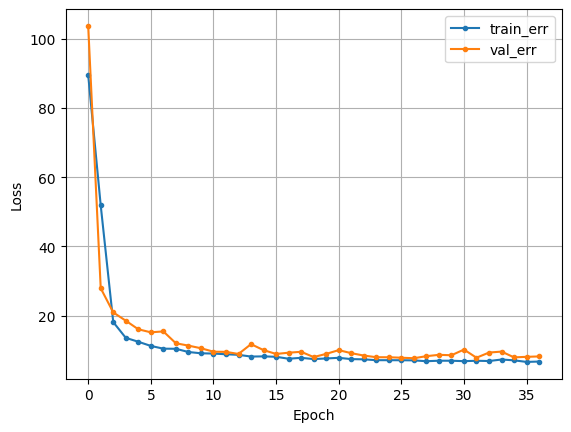

4/4 [==============================] - 1s 9ms/step
RMSE : 14.209130250417804
MAE : 7.72130066914434
MAPE : 4333004958029141.5
R2 Score : 0.39384930579475796


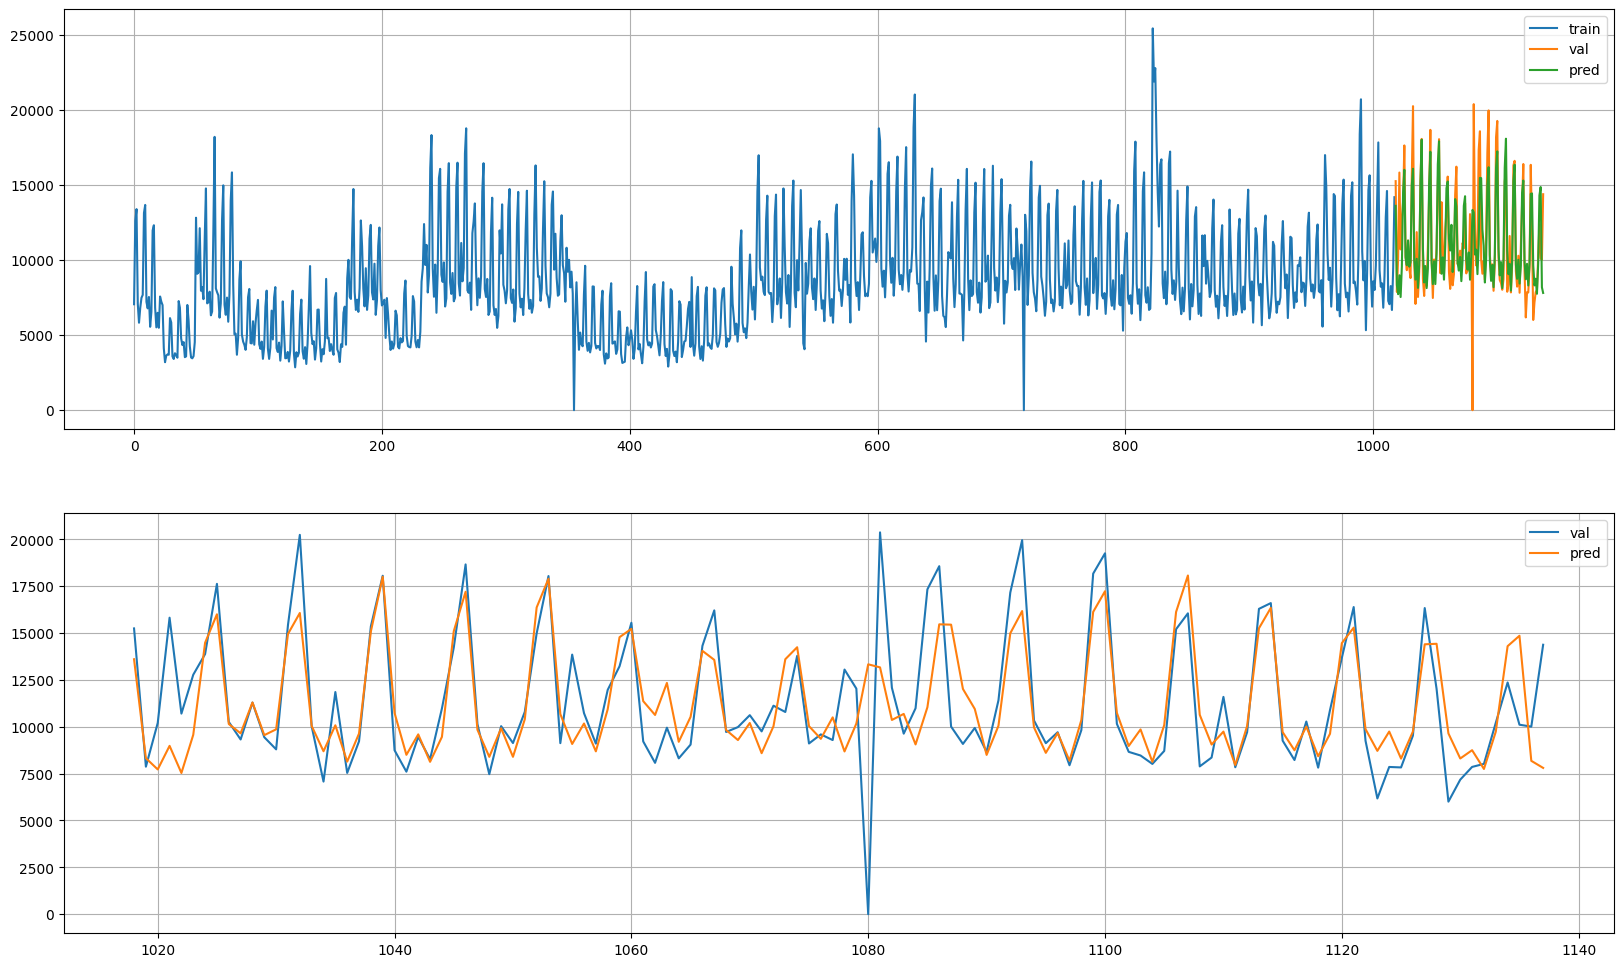

In [ ]:
dl_history_plot(history)

# 예측
y_pred = model_lstm.predict(x_val)


# 성능평가
print('RMSE :', mean_squared_error(y_val, y_pred)**0.5)
print('MAE :', mean_absolute_error(y_val, y_pred))
print('MAPE :', mean_absolute_percentage_error(y_val, y_pred))
print('R2 Score :', r2_score(y_val, y_pred))

# 결과 plotting
y_train = y_train**2
y_val = y_val**2
y_pred = y_pred**2

plot_model_result(y_train, y_val, y_pred)

## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
y_train = y_train**0.5
y_val = y_val**0.5


* **모델링**

In [ ]:
clear_session()

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=10, kernel_size=2, padding='same', input_shape=x_train[0].shape))
model_cnn.add(Flatten())
model_cnn.add(Dense(10, activation='relu'))
model_cnn.add(Dense(1))

model_cnn.summary()
model_cnn.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 10)             530       
                                                                 
 flatten (Flatten)           (None, 70)                0         
                                                                 
 dense (Dense)               (None, 10)                710       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1251 (4.89 KB)
Trainable params: 1251 (4.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   restore_best_weights=True)
history = model_cnn.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val), callbacks=[es]).history

Epoch 1/500
32/32 [==============================] - 1s 8ms/step - loss: 8310.9580 - val_loss: 10939.8760
Epoch 2/500
32/32 [==============================] - 0s 4ms/step - loss: 7934.1821 - val_loss: 10127.6729
Epoch 3/500
32/32 [==============================] - 0s 4ms/step - loss: 6964.9658 - val_loss: 8146.2969
Epoch 4/500
32/32 [==============================] - 0s 4ms/step - loss: 4972.6074 - val_loss: 4865.4810
Epoch 5/500
32/32 [==============================] - 0s 4ms/step - loss: 2417.8564 - val_loss: 1745.4617
Epoch 6/500
32/32 [==============================] - 0s 4ms/step - loss: 732.7537 - val_loss: 564.1056
Epoch 7/500
32/32 [==============================] - 0s 4ms/step - loss: 362.6264 - val_loss: 482.8215
Epoch 8/500
32/32 [==============================] - 0s 4ms/step - loss: 342.1889 - val_loss: 471.3805
Epoch 9/500
32/32 [==============================] - 0s 4ms/step - loss: 332.7575 - val_loss: 460.3665
Epoch 10/500
32/32 [==============================] - 0s 4ms/

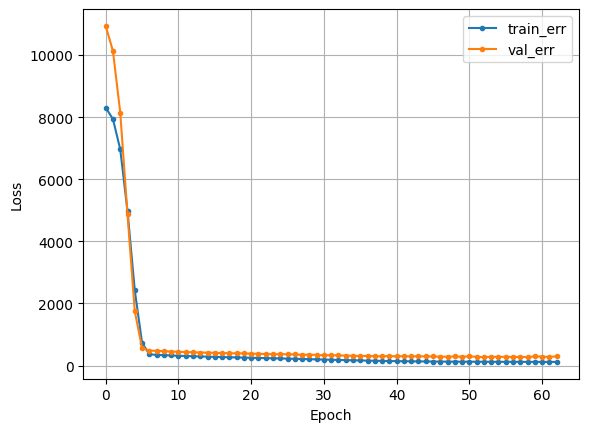

4/4 [==============================] - 0s 3ms/step
RMSE : 16.475853439765615
MAE : 9.987289793104393
MAPE : 4862447008262827.0
R2 Score : 0.1850303110812076


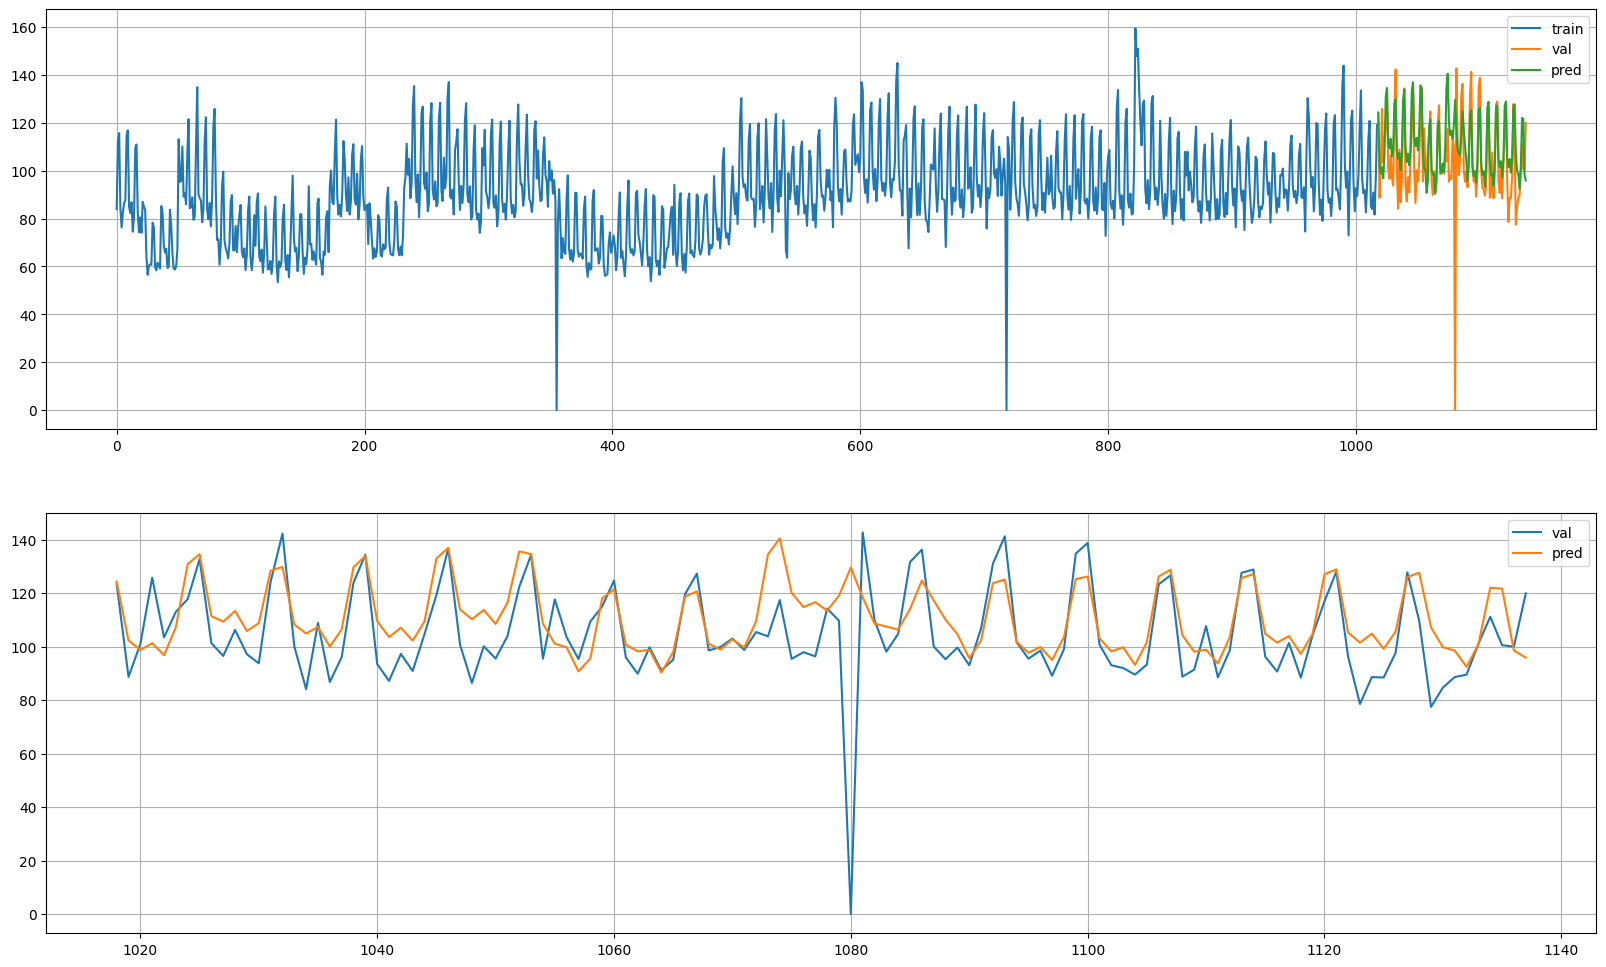

In [ ]:
dl_history_plot(history)

# 예측
y_pred = model_cnn.predict(x_val)


# 성능평가
print('RMSE :', mean_squared_error(y_val, y_pred)**0.5)
print('MAE :', mean_absolute_error(y_val, y_pred))
print('MAPE :', mean_absolute_percentage_error(y_val, y_pred))
print('R2 Score :', r2_score(y_val, y_pred))

# 결과 plotting
plot_model_result(y_train, y_val, y_pred)

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

In [ ]:
def pipeline(oil_price, orders, sales, products, stores, Product_ID, Store_ID, scaler):
    sales['Date'] = pd.to_datetime(sales['Date'] )
    oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
    orders['Date'] = pd.to_datetime(orders['Date'] )

    # 공휴일 데이터
    cal = UnitedStates()
    holiday = pd.DataFrame()
    for y in range(2014, 2018) :
        holiday = pd.concat([holiday, pd.DataFrame(cal.holidays(y))], axis = 0)

    holiday.columns = ['Date', 'holiday']
    holiday['Date'] = pd.to_datetime(holiday['Date'])
    holiday['holiday'] = 1 # 휴일은 1

    # Store_ID 와 Product_ID 데이터만 merge
    lead_time = products.loc[products['Product_ID'] == Product_ID]['LeadTime'].item()
    sale = sales.loc[(sales['Store_ID'] == Store_ID)&(sales['Product_ID'] == Product_ID)][['Date','Qty']]
    order = orders.loc[(orders['Store_ID'] == Store_ID)][['Date','CustomerCount']]
    sale_order_merge = pd.merge(sale, order, on = 'Date', how = 'left')
    sale_order_merge['target'] = sale_order_merge['Qty'].shift(-lead_time)
    sale_order_merge.dropna(axis = 0, inplace = True)

    #date
    sale_order_merge['year'] = sale_order_merge['Date'].dt.year
    sale_order_merge['day'] = sale_order_merge['Date'].dt.day
    sale_order_merge['weekday'] = sale_order_merge['Date'].dt.weekday
    sale_order_merge['Month'] = sale_order_merge['Date'].dt.month
    #hour은 모두 0시로 통일되어있음

    #same_category 의미가있나.?
    same_cate = products.loc[products['Product_ID']==Product_ID]['Category'].item()
    product_id = products.loc[products['Category']==same_cate]['Product_ID'].tolist()
    same_category = sales.loc[(sales['Store_ID'] == Store_ID)&(sales['Product_ID'].isin(product_id))].groupby('Date',as_index = False)[['Qty']].sum()
    same_category.rename(columns ={"Qty": 'Category_Qty'},inplace = True)
    sale_order_merge = pd.merge(sale_order_merge, same_category, on = 'Date', how = 'left')

    store_type = stores.loc[stores['Store_ID']==Store_ID]['Store_Type'].item()
    city = stores.loc[stores['Store_ID']==Store_ID]['City'].item()
    store_id = stores.loc[(stores['City']==city)&(stores['Store_Type']==store_type)]['Store_ID'].tolist()
    same_type_store = orders.loc[orders['Store_ID'].isin(store_id)].groupby('Date',as_index = False)[['CustomerCount']].sum()
    same_type_store.rename(columns ={"CustomerCount": 'Sametype_CustomerCount'},inplace = True)
    sale_order_merge = pd.merge(sale_order_merge, same_type_store, on = 'Date', how = 'left')

    # 2.4 oil price MA14
    sale_order_merge = pd.merge(sale_order_merge, oil_price, on = 'Date', how = 'left')
    sale_order_merge['WTI_Price'] = sale_order_merge['WTI_Price'].rolling(14, min_periods=1).mean()

    sale_order_merge['Customer_congestion'] = np.where(sale_order_merge['CustomerCount'] <= 3500, 0,
                                    np.where(sale_order_merge['CustomerCount'] <= 4500, 1,
                                            np.where(sale_order_merge['CustomerCount'] <= 6000, 2, 3)))

    #공휴일추가
    sale_order_merge=pd.merge(sale_order_merge,holiday,how='left')
    sale_order_merge = sale_order_merge.fillna({'holiday':0}) # 휴일이 아닌 날은 0
    sale_order_merge['holiday'] = np.where(sale_order_merge['weekday'].isin([5, 6]), 1, 0) # 주말도 휴무일에 넣음

    df = sale_order_merge.copy()
    df = df.drop(columns=['Date'])

    # 가변수화
    cat_cols = ['Month', 'weekday']
    df = pd.get_dummies(df, columns=cat_cols ,drop_first=True)

    # scaling 시에 없던 feature 추가
    for name in scaler.feature_names_in_:
        if not name in df.columns:
            df[name] = 0

    # X, y 분리
    target = 'target'
    X = df.drop(target, axis=1)
    y = df.loc[:, target]

    X = X[scaler.feature_names_in_]  # 훈련된 컬럼 순서와 맞추기

    # 스케일링
    X = scaler.transform(X)
    y = y**0.5

    # 3차원 구조화
    X2, y2 = temporalize(X, y, 7)

    x_test, y_test = X2, y2
    return x_test, y_test



## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [ ]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [ ]:
x_test, y_test = pipeline(oil_price_test, orders_test, sales_test, products, stores, 3, 44, scaler_x)

In [ ]:
y_pred = model_lstm.predict(x_test)
print('RMSE :', mean_squared_error(y_test, y_pred)**0.5)
print('MAE :', mean_absolute_error(y_test, y_pred))
print('MAPE :', mean_absolute_percentage_error(y_test, y_pred))
print('R2 Score :', r2_score(y_test, y_pred))

1/1 [==============================] - 0s 22ms/step
RMSE : 7.431672296283355
MAE : 5.974773064549377
MAPE : 0.05580855213974507
R2 Score : 0.8370698454188361


In [ ]:
y_pred = model_cnn.predict(x_test)
print('RMSE :', mean_squared_error(y_test, y_pred)**0.5)
print('MAE :', mean_absolute_error(y_test, y_pred))
print('MAPE :', mean_absolute_percentage_error(y_test, y_pred))
print('R2 Score :', r2_score(y_test, y_pred))

1/1 [==============================] - 0s 26ms/step
RMSE : 9.693774645559742
MAE : 8.069302207710512
MAPE : 0.08139652040563844
R2 Score : 0.7227866084178731


* 예측해보기

# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [ ]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [ ]:
inv_simulator(y_test**2, y_pred**2, 9500, 8)

일평균 재고량     : 15118.762
일평균 재고 금액  : 120950.096
일평균 재고회전율 : 0.861
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,8816.0,7098.0,18316,9500,14419,8816,0.0
1,10087.0,8918.0,19587,9500,16409,10087,0.0
2,15131.0,14419.0,23919,8788,9965,14419,0.0
3,18556.0,16409.0,25197,6641,10120,16409,0.0
4,8803.0,9253.0,16606,7803,10696,9965,0.0
5,8690.0,7261.0,17923,9233,7177,10120,0.0
6,9199.0,8999.0,19929,10730,7595,10696,0.0
7,8148.0,6910.0,17907,9759,13988,7177,0.0
8,11616.0,8825.0,17354,5738,19874,7595,0.0
9,16510.0,14247.0,19726,3216,16014,13988,0.0
